# Fitting Signal Detection Measures to ROC Curves

In [86]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from sklearn.utils import check_consistent_length
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

## Main Functions
[1] Robert R. Sokal and F. James Rohlf. Biometry: The Principles and Practices of Statistics in BiologicalResearch. W.H. Freeman, 3 edition, 1994  
[2] Hoey, J. (2012). The Two-Way Likelihood Ratio (G) Test and Comparison to Two-Way Chi Squared Test.

In [2]:
def compute_dprime(tp, fp):
    # untested
    return stats.norm.ppf(tp) - stats.norm.ppf(fp)

def compute_c_bias(tp, fp):
    # untested
    return - 0.5 * (stats.norm.ppf(tp) + stats.norm.ppf(fp))

def accumulate(*arrays):
    # untested
    out = []
    for a in arrays:
        accumulated = np.cumsum(a)
        out.append(accumulated)
    return out

def to_freq(*arrays):
    # untested
    out = []
    for a in arrays:
        converted = np.array([(x + i / len(a)) / (max(a)+1) for i, x in enumerate(a, start=1)])
        out.append(converted)
    return out

def convert_to_roc(a, b):
    # untested
    a_c, b_c = accumulate(a, b)
    a_f, b_f = to_freq(a_c, b_c)
    return a_f, b_f

def g_test(x, x_freq, expected, x_max):
    # untested
    # Refs: [1, 2]
    # Two-way log-likelihood G-test
    # Implementation issues:
    #    depending on minimization starting variables, the log expressions can throw errors from negative values and div/0 etc. Numpy just warns and continues.
    a = 2 * x * np.log(x_freq / expected) 
    b = 2 * (x_max - x) * np.log((1 - x_freq) / (1 - expected))
    return a + b

def threshold_model_expectation(R, noise_frequency):
    # untested
    # Get the expected values for signals and noises
    expected_signal = ((1 - R) * noise_frequency + R)[:-1]
    expected_noise = noise_frequency[:-1]
    return expected_signal, expected_noise

def signal_detection_model_expectation(d, c):
    # untested
    expected_signal = stats.norm.cdf(d / 2 - c)
    expected_noise = stats.norm.cdf(-d / 2 - c)
    return expected_signal, expected_noise

def dual_process_model_expectation(R, d, c):
    # untested
    expected_signal = R + (1 - R) * stats.norm.cdf(d / 2 - c)
    expected_noise = stats.norm.cdf(-d / 2 - c)
    return expected_signal, expected_noise

def detection_model(parameters, labels, signal, noise, model='sdt', optimizing=False):
    # untested
    # model options: 'threshold', 'sdt', 'dpsdt', 'thresh'
    
    # Implementation issues:
    #    parameters and labels are specified as separate ndarrays arrays because of how the optimizer works. Maybe this can be improved?
    
    #------------------------- Check Inputs ---------------------------#
    # Ensure equal length
    check_consistent_length(signal, noise)
    check_consistent_length(parameters, labels)
    
    # Accumulate (c) the signal and noise data
    signal_c, noise_c = accumulate(signal, noise) # np.cumsum(signal), np.cumsum(noise)
    # Get frequencies for the cumulative signal and noise
    signal_f, noise_f = to_freq(signal_c, noise_c)
    
    #------------------------- Model Specific -------------------------#
    if model == 'sdt':
        if 'd' not in labels:
            raise ValueError(f"Either or both of `R` and `d` not specified in parameter labels. labels specified were: {labels}.")
        d = parameters[labels == 'd'].item()
        c = parameters[(labels!='R') & (labels!='d')] # Can c_values be 0? what about 1?
        exp_signal, exp_noise = signal_detection_model_expectation(d, c)
        
    elif model == 'dpsdt':
        if ('R' not in labels) or ('d' not in labels):
            raise ValueError(f"Either or both of `R` and `d` not specified in parameter labels. labels specified were: {labels}.")
        # Grab the R and d values
        R = parameters[labels == 'R'].item()
        d = parameters[labels == 'd'].item()
    
        c = parameters[(labels!='R') & (labels!='d')] # Can c_values be 0? what about 1?
        # Get the expected values for signals and noises
        exp_signal, exp_noise = dual_process_model_expectation(R, d, c)
    
    elif model == 'thresh':
        if ('R' not in labels):
            raise ValueError(f"Either or both of `R` and `d` not specified in parameter labels. labels specified were: {labels}.")
        R = parameters[labels == 'R'].item()
        exp_signal, exp_noise = threshold_model_expectation(R, noise_f)
    #------------------------------------------------------------------#

    # Compute the gsquared using the dual process model parameters
    #   Still getting runtime warnings about division. Function only works with numpy, so can't use math.
    signal_gsquared = g_test(x=signal_c[:-1], x_freq=signal_f[:-1], expected=exp_signal, x_max=signal_c.max())
    noise_gsquared = g_test(x=noise_c[:-1], x_freq=noise_f[:-1], expected=exp_noise, x_max=noise_c.max())
    
    g_squared_summed = np.sum([signal_gsquared, noise_gsquared])
    
    if optimizing:
        return g_squared_summed
    else:
        return g_squared_summed, exp_signal, exp_noise


def optimize_model(objective, labels, signal, noise, model, iterations=25, parameters=None, verbose=True):
    for i in range(iterations):
        try:
            if not parameters:
                # Random parameter initialization (default)
                parameters = np.random.uniform(-.5, .5, len(labels))
                optimizing = True # must set in order to return just the objective function
                
            opt = minimize(fun=objective, x0=parameters, args=(labels, signal, noise, model, optimizing), tol=1e-4)
            if opt.success:
                # Converged at (local?) minimum.
                if verbose==True:
                    print(opt)
                else:
                    print("Optimisation successful\n")
                break
            else:
                raise ValueError("Optimisation unsuccessful")
        except:
            opt = None
    return opt

## Testing the different models with example data

In [3]:
# Example data
signal = [508,224,172,135,119,63] # Signal present examples
noise = [102,161,288,472,492,308] # Signal absent examples

### 1.1. signal detection model

In [4]:
# Arguments
# Parameters randomly set in the fit_model function
parameters = np.array([1.12279662339189, 0.871166834070118, 0.405779553457989, -0.0588639712751784, -0.644343940682155, -1.42214656169388])
labels = np.array(['d', 'c1', 'c2', 'c3', 'c4', 'c5'])
expected = 91.8424069319085

model_fit, s, n = detection_model(parameters=parameters, labels=labels, signal=signal, noise=noise, model='sdt')

np.allclose(model_fit, expected)
print(f"expected G\N{SUPERSCRIPT TWO}: {expected}\nfound G\N{SUPERSCRIPT TWO}:{model_fit}")

expected G²: 91.8424069319085
found G²:91.84240693190836


#### 1.2. Optimizing signal detection model

In [5]:
opt = optimize_model(objective=detection_model, labels=labels, signal=signal, noise=noise,model='sdt')

if opt:
    if opt.success:
        optimal_sdt_parameters = {l:v for l, v in zip(labels, opt.x)}
        print(f"optimal parameters found:\n{optimal_sdt_parameters}")
        sdt_g, sdt_signal, sdt_noise = detection_model(parameters=parameters, labels=labels, signal=signal, noise=noise, model='sdt')
else:
    print("Failure.")

      fun: 91.84240692669364
 hess_inv: array([[ 2.94483396e-04,  2.12059986e-05, -1.12331411e-05,
        -3.68062196e-05, -5.69357840e-05, -8.71700921e-05],
       [ 2.12059986e-05,  3.71882206e-04,  2.12058140e-05,
        -8.87457865e-06, -5.42396879e-06, -1.11512554e-05],
       [-1.12331411e-05,  2.12058140e-05,  2.82910444e-04,
         4.26693398e-06, -1.07514522e-06,  2.15318960e-05],
       [-3.68062196e-05, -8.87457865e-06,  4.26693398e-06,
         2.82794051e-04, -1.55629950e-06,  8.93646801e-06],
       [-5.69357840e-05, -5.42396879e-06, -1.07514522e-06,
        -1.55629950e-06,  2.87849459e-04,  1.86884867e-05],
       [-8.71700921e-05, -1.11512554e-05,  2.15318960e-05,
         8.93646801e-06,  1.86884867e-05,  4.85949402e-04]])
      jac: array([ 3.05175781e-05,  2.00271606e-05, -2.28881836e-05, -3.81469727e-06,
        1.23977661e-05,  3.33786011e-05])
  message: 'Optimization terminated successfully.'
     nfev: 208
      nit: 17
     njev: 26
   status: 0
  success:

### 2.1. dual process model

In [48]:
parameters = np.array([0.329619769943936, 0.669264105874664, 1.30349820023126, 0.683947212600267, 0.145604921894773, -0.473844533479801, -1.25079084398587])
labels = np.array(['R', 'd', 'c1', 'c2', 'c3', 'c4', 'c5'])
expected = 22.6109004733713

model_fit, s, n = detection_model(parameters=parameters, labels=labels, signal=signal, noise=noise, model='dpsdt')

np.allclose(model_fit, expected)
print(f"expected G\N{SUPERSCRIPT TWO}: {expected}\nfound G\N{SUPERSCRIPT TWO}:{model_fit}")

expected G²: 22.6109004733713
found G²:22.61090047337164


#### 2.2. Optimizing dual-process model

In [50]:
opt = optimize_model(objective=detection_model, labels=labels, signal=signal, noise=noise, iterations=500, model='dpsdt')

if opt:
    if opt.success:
        optimal_dpsdt_parameters = {l:v for l, v in zip(labels, opt.x)}
        print(f"optimal parameters found:\n{optimal_dpsdt_parameters}")
        
else:
    print("Failure.")

      fun: 22.610900467600505
 hess_inv: array([[ 0.0003613 , -0.00068959,  0.00055979,  0.00043419,  0.00032809,
         0.00027387,  0.00026785],
       [-0.00068959,  0.00176426, -0.00118333, -0.00093032, -0.00072099,
        -0.00063313, -0.00064167],
       [ 0.00055979, -0.00118333,  0.00175269,  0.00070692,  0.00054181,
         0.0004546 ,  0.00044817],
       [ 0.00043419, -0.00093032,  0.00070692,  0.00099717,  0.00040994,
         0.00035769,  0.0003533 ],
       [ 0.00032809, -0.00072099,  0.00054181,  0.00040994,  0.00065591,
         0.0002679 ,  0.00026653],
       [ 0.00027387, -0.00063313,  0.0004546 ,  0.00035769,  0.0002679 ,
         0.00055638,  0.00023101],
       [ 0.00026785, -0.00064167,  0.00044817,  0.0003533 ,  0.00026653,
         0.00023101,  0.00070089]])
      jac: array([-6.74724579e-05,  3.57627869e-05, -5.19752502e-05,  8.10623169e-06,
        3.52859497e-05,  3.64780426e-05,  5.72204590e-05])
  message: 'Optimization terminated successfully.'
     n

### 3.1. threshold model

In [51]:
parameters = np.array([0.520274590415736])
labels = np.array(['R'])
expected = 163.275256078908
model_fit, s, n = detection_model(parameters=parameters, labels=labels, signal=signal, noise=noise, model='thresh')

np.allclose(model_fit, expected)
print(f"expected G\N{SUPERSCRIPT TWO}: {expected}\nfound G\N{SUPERSCRIPT TWO}:{model_fit}")

expected G²: 163.275256078908
found G²:163.27525607890783


#### 3.2. Optimizing threshold model

This one gives errors and needs more work. It does work if you run it enough times.

In [84]:
opt = optimize_model(objective=detection_model, labels=labels, signal=signal, noise=noise, model='thresh')

if opt:
    if opt.success:
        optimal_threshold_parameters = {l:v for l, v in zip(labels, opt.x)}
        print(f"optimal parameters found:\n{optimal_threshold_parameters}")
else:
    print("Failure.")

      fun: 163.27525607888887
 hess_inv: array([[4.14111663e-05]])
      jac: array([1.71661377e-05])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([0.52027462])
optimal parameters found:
{'R': 0.5202746246119617}


# Plotting

Familiarity = 0.5749633372613551
Recollection = 0.32962093952311317


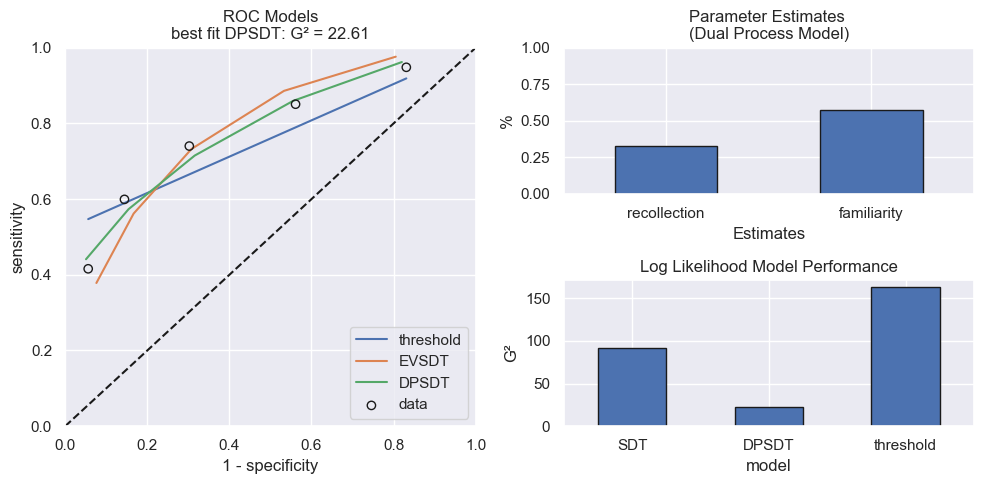

In [87]:
sdt_g, sdt_signal, sdt_noise = detection_model(parameters=np.array(list(optimal_sdt_parameters.values())),
                                               labels=np.array(list(optimal_sdt_parameters.keys())),
                                               signal=signal,
                                               noise=noise,
                                               model='sdt')

dpsdt_g, dpsdt_signal, dpsdt_noise = detection_model(parameters=np.array(list(optimal_dpsdt_parameters.values())),
                                                     labels=np.array(list(optimal_dpsdt_parameters.keys())),
                                                     signal=signal,
                                                     noise=noise,
                                                     model='dpsdt')

threshold_g, threshold_signal, threshold_noise = detection_model(parameters=np.array(list(optimal_threshold_parameters.values())),
                                                                 labels=np.array(list(optimal_threshold_parameters.keys())),
                                                                 signal=signal,
                                                                 noise=noise,
                                                                 model='thresh')

performances = {'SDT':sdt_g, 'DPSDT':dpsdt_g, 'threshold':threshold_g}

# Find best fit
best_fit_g = performances[min(performances)]
best_fit_model = min(performances, key=performances.get)



fig = plt.figure(figsize=(10,5), dpi=100)
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,4)


# ROC Curves
ax0.set_xlim(0, 1); ax0.set_ylim(0, 1)
ax0.plot([0,1],[0,1], c='k',ls='dashed')

# Plot the models
ax0.plot(threshold_noise, threshold_signal, label='threshold')
ax0.plot(sdt_noise, sdt_signal, label='EVSDT')
ax0.plot(dpsdt_noise, dpsdt_signal, label='DPSDT')

# Plot the data
roc_signal, roc_noise = convert_to_roc(signal, noise)
ax0.scatter(roc_noise[:-1], roc_signal[:-1], facecolors='none', edgecolors='k', label='data', zorder=10)

ax0.set_xlabel('1 - specificity')
ax0.set_ylabel('sensitivity')

ax0.set_title(f"ROC Models\nbest fit {best_fit_model}: G\N{SUPERSCRIPT TWO} = {best_fit_g:.2f}")
ax0.legend()


# Parameter Estimates plot
c_values = [int(c[-1]) for c in list(optimal_dpsdt_parameters.keys())[2:]]
median_c = np.median(c_values)
recollection = optimal_dpsdt_parameters['R']
familiarity = stats.norm.cdf(optimal_dpsdt_parameters['d']/ 2 - optimal_dpsdt_parameters['c'+str(int(median_c))])
parameter_estimates = pd.Series({'recollection':recollection, 'familiarity':familiarity})

print(f"Familiarity = {familiarity}\nRecollection = {recollection}")

parameter_estimates.plot(kind='bar', edgecolor='k', rot=0, title='Parameter Estimates \n(Dual Process Model)', ax=ax1)
ax1.set_xlabel('Estimates')
ax1.set_ylabel('%')
ax1.set_ylim(0,1)

# Model Performance plot
pd.Series(performances).plot(kind='bar', edgecolor='k', rot=0, title='Log Likelihood Model Performance', ax=ax2)
ax2.set_xlabel('model')
ax2.set_ylabel('G\N{SUPERSCRIPT TWO}')


plt.tight_layout()
plt.show()